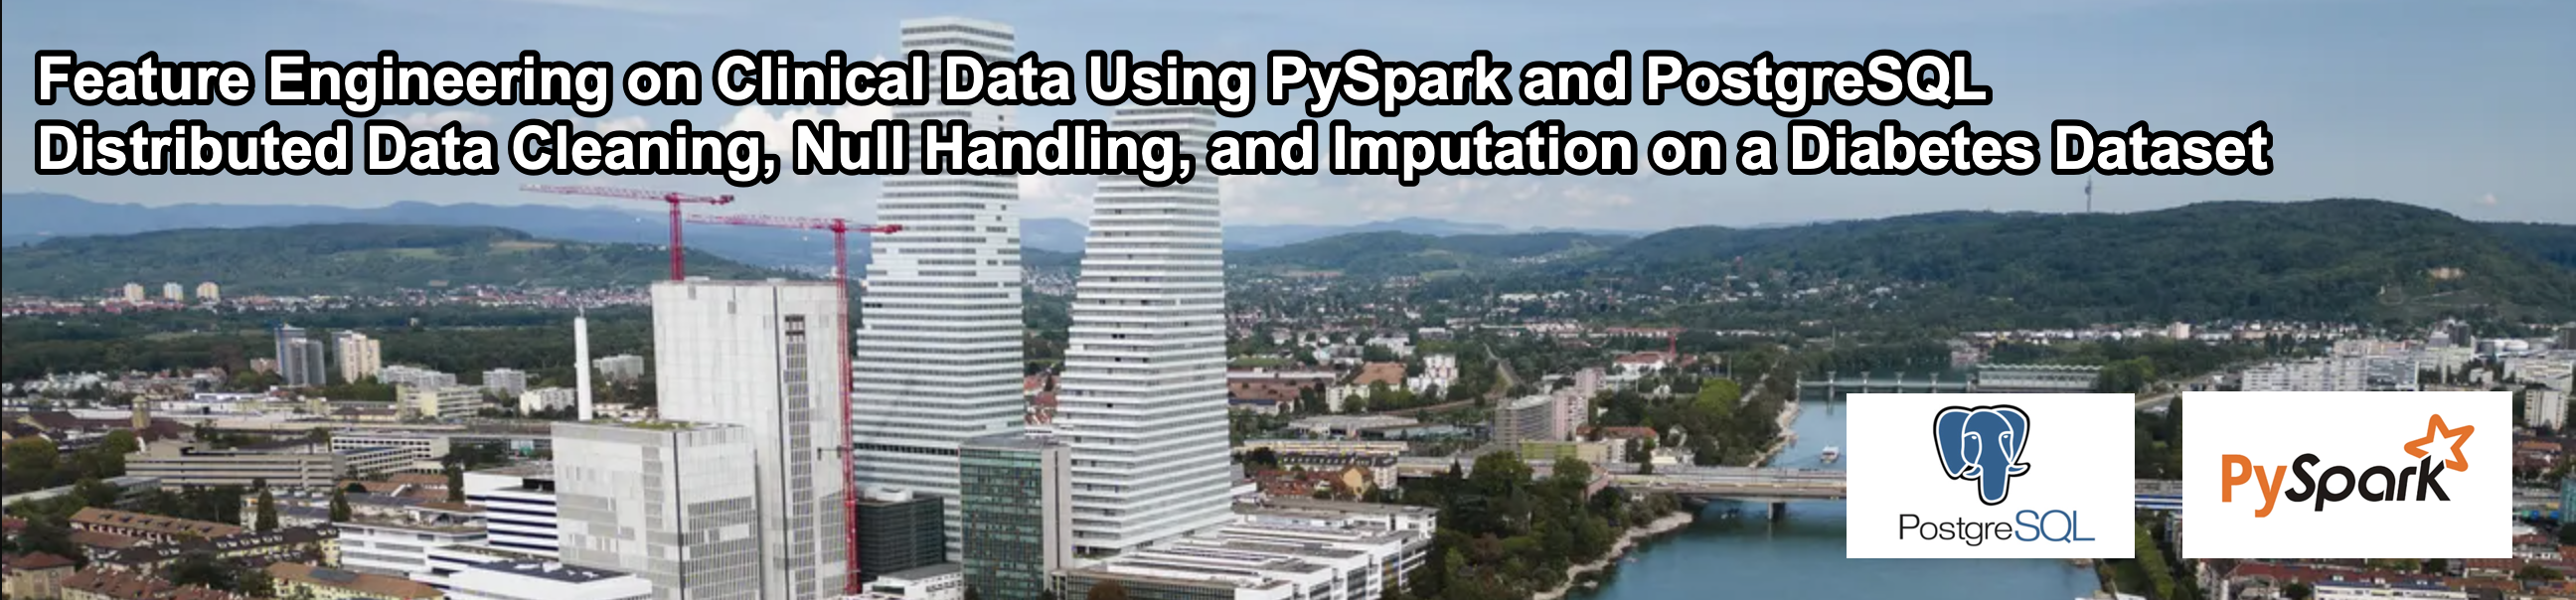

### Introduction of NA Values and loading data

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
csv_path = "diabetes.csv"
df = pd.read_csv(csv_path)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
import numpy as np
np.random.seed(42)
df_with_nulls = df.copy()

# Create some rows with >50% nulls
num_rows = len(df)
num_cols = len(df.columns)

# Get all columns except Outcome
columns_to_null = [col for col in df.columns if col != 'Outcome']

# For 10% of the rows, set 6 out of 8 columns to null (75% nulls)
rows_with_many_nulls = np.random.choice(num_rows, size=int(num_rows*0.1), replace=False)
for row in rows_with_many_nulls:
    # Randomly select 6 columns to set to null (from the 8 available columns)
    cols_to_null = np.random.choice(columns_to_null, size=6, replace=False)
    df_with_nulls.loc[row, cols_to_null] = np.nan

# For 20% of rows, set exactly 3 columns to null (37.5% nulls)
rows_with_some_nulls = np.random.choice(
    [i for i in range(num_rows) if i not in rows_with_many_nulls],
    size=int(num_rows*0.2),
    replace=False
)
for row in rows_with_some_nulls:
    # Always select exactly 3 columns to set to null (from the 8 available columns)
    cols_to_null = np.random.choice(columns_to_null, size=3, replace=False)
    df_with_nulls.loc[row, cols_to_null] = np.nan

In [4]:
df_with_nulls

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,NaN,0.0,NaN,0.351,NaN,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0
764,2.0,NaN,NaN,27.0,NaN,NaN,NaN,NaN,0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0
766,1.0,126.0,60.0,0.0,0.0,NaN,NaN,NaN,1


### Load data into Postgres Database

In [5]:
# PostgreSQL connection config
DB_USER = "myuser"
DB_PASS = "mypassword"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "mydatabase"

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

print("Engine dialect is:", engine.dialect.name)

# Upload DataFrame
table_name = "diabetes_table"

df_with_nulls.to_sql(table_name, con=engine, index=False, if_exists="replace")

print(f"✅ Uploaded to table '{table_name}'")

Engine dialect is: postgresql
✅ Uploaded to table 'diabetes_table'


In [6]:
query = "SELECT * FROM diabetes_table"
diabetes_db = pd.read_sql(query, con=engine)

print("✅ Data loaded from PostgreSQL")
diabetes_db

✅ Data loaded from PostgreSQL


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,NaN,0.0,NaN,0.351,NaN,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0
764,2.0,NaN,NaN,27.0,NaN,NaN,NaN,NaN,0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0
766,1.0,126.0,60.0,0.0,0.0,NaN,NaN,NaN,1


### Spark Configurations and Libraries

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, min, max, mean, reduce

In [8]:
# Initialize Spark Session with optimized settings for M3 MacBook
#spark = SparkSession.builder \
#    .appName("DiabetesFeatureEngineering") \
#    .config("spark.jars.packages", "org.postgresql:postgresql:42.7.1") \
#    .config("spark.executor.cores", "4") \
#   .config("spark.executor.memory", "4g") \
#    .config("spark.driver.memory", "4g") \
#    .config("spark.default.parallelism", "8") \
#    .getOrCreate()

In [31]:
# As we have a small dataset, we used this configuration
spark = SparkSession.builder \
    .appName("DiabetesFeatureEngineering") \
    .master("local[*]") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.7.1") \
    .getOrCreate()


#### 1. Pull the dataset from the database

In [10]:
def load_data_from_postgres():
    # PostgreSQL connection properties
    postgres_properties = {
        "user": "myuser",
        "password": "mypassword",
        "driver": "org.postgresql.Driver"
    }
    
    # JDBC URL
    jdbc_url = "jdbc:postgresql://localhost:5432/mydatabase"
    
    # Load data
    df = spark.read \
        .format("jdbc") \
        .option("url", jdbc_url) \
        .option("dbtable", "diabetes_table") \
        .option("user", postgres_properties["user"]) \
        .option("password", postgres_properties["password"]) \
        .option("driver", postgres_properties["driver"]) \
        .load()
    
    return df

In [32]:
df = load_data_from_postgres()
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|        6.0|  148.0|         72.0|         35.0|    0.0|33.6|                   0.627|50.0|      1|
|        1.0|   85.0|         66.0|         NULL|    0.0|NULL|                   0.351|NULL|      0|
|        8.0|  183.0|         64.0|          0.0|    0.0|23.3|                   0.672|32.0|      1|
|        1.0|   89.0|         66.0|         23.0|   94.0|28.1|                   0.167|21.0|      0|
|        0.0|  137.0|         40.0|         35.0|  168.0|43.1|                   2.288|33.0|      1|
|        5.0|  116.0|         74.0|          0.0|    0.0|25.6|                   0.201|30.0|      0|
|        3.0|   78.0|         50.0|         32.0|   88.0|31.0|                   0.248|26.0

#### 2. Split the data between train and test

In [12]:
def split_data(df):
    train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
    return train_df, test_df

In [13]:
train_df, test_df = split_data(df)
train_df.show()


+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|       NULL|   NULL|         NULL|         NULL|   NULL|NULL|                    0.15|29.0|      1|
|       NULL|   NULL|         NULL|         NULL|   NULL|NULL|                    0.28|39.0|      0|
|       NULL|   NULL|         NULL|         NULL|   NULL|NULL|                    0.84|58.0|      0|
|       NULL|   NULL|         NULL|         NULL|   NULL|25.0|                   0.206|NULL|      0|
|       NULL|   NULL|         NULL|         NULL|   NULL|27.5|                   0.141|NULL|      1|
|       NULL|   NULL|         NULL|         NULL|   NULL|29.3|                    NULL|34.0|      0|
|       NULL|   NULL|         NULL|         NULL|   NULL|42.7|                   0.845|NULL

In [14]:
test_df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|       NULL|   NULL|         NULL|         NULL|   NULL|NULL|                   0.687|62.0|      0|
|       NULL|   NULL|         NULL|         NULL|   NULL|28.9|                    NULL|23.0|      1|
|       NULL|   NULL|         NULL|         NULL|   NULL|39.2|                    NULL|58.0|      1|
|       NULL|   NULL|         NULL|         NULL|    0.0|30.8|                    NULL|NULL|      0|
|       NULL|   NULL|         NULL|         28.0|  135.0|34.2|                   0.142|22.0|      0|
|       NULL|   NULL|         NULL|         36.0|  120.0|NULL|                    NULL|NULL|      1|
|       NULL|   NULL|         62.0|          7.0|   NULL|NULL|                    NULL|NULL

#### 3. Get the min and max of all numerical variables (or at least 3) using the dataframe API

In [15]:
numerical_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
                  "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

In [16]:
def get_min_max(df, numerical_cols):
    min_max_df = df.agg(
        *[min(col(c)).alias(f"min_{c}") for c in numerical_cols],
        *[max(col(c)).alias(f"max_{c}") for c in numerical_cols]
    )
    return min_max_df

In [17]:
min_max_df = get_min_max(train_df, numerical_cols)
min_max_df.show()

+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+
|min_Pregnancies|min_Glucose|min_BloodPressure|min_SkinThickness|min_Insulin|min_BMI|min_DiabetesPedigreeFunction|min_Age|max_Pregnancies|max_Glucose|max_BloodPressure|max_SkinThickness|max_Insulin|max_BMI|max_DiabetesPedigreeFunction|max_Age|
+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+
|            0.0|        0.0|              0.0|              0.0|        0.0|    0.0|                       0.078|   21.0|           17.0|      198.0|            122.0|             99.0|      744.0|   67.1|                        2.42|   81.0|
+---------------+-------

#### 4. Get the mean of all numerical variables (or at least 3) using Spark SQL queries. 

In [18]:
def get_mean(df, numerical_cols):
    mean_df = df.agg(
        *[mean(col(c)).alias(f"mean_{c}") for c in numerical_cols]
    )
    return mean_df

In [19]:
mean_df = get_mean(train_df, numerical_cols)
mean_df.show()

+-----------------+------------------+------------------+------------------+----------------+-----------------+-----------------------------+-----------------+
| mean_Pregnancies|      mean_Glucose|mean_BloodPressure|mean_SkinThickness|    mean_Insulin|         mean_BMI|mean_DiabetesPedigreeFunction|         mean_Age|
+-----------------+------------------+------------------+------------------+----------------+-----------------+-----------------------------+-----------------+
|3.738095238095238|120.33574007220217|  69.2165137614679|20.341113105924595|80.5090579710145|31.84468468468469|          0.46384201077199266|32.53860294117647|
+-----------------+------------------+------------------+------------------+----------------+-----------------+-----------------------------+-----------------+



#### 5. Drop the rows with more than 50% of NA values

In [22]:
from functools import reduce
from operator import add

def drop_rows_with_many_nulls(df, threshold=0.5):
    num_cols = len(df.columns)
    null_count_exprs = [when(col(c).isNull(), 1).otherwise(0) for c in df.columns]
    sum_expr = reduce(add, null_count_exprs)
    
    return df.withColumn("null_count", sum_expr) \
             .filter(col("null_count") <= (num_cols * threshold)) \
             .drop("null_count")

In [23]:
# Drop rows with too many NA values
filtered_df = drop_rows_with_many_nulls(train_df)
print(f"Rows before filtering: {train_df.count()}")
print(f"Rows after filtering: {filtered_df.count()}")
filtered_df.show()

Rows before filtering: 645
Rows after filtering: 588
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|       NULL|   NULL|         NULL|          0.0|    0.0|33.3|                   1.114|33.0|      1|
|       NULL|   NULL|         52.0|         NULL|   36.0|27.8|                   0.269|22.0|      0|
|       NULL|   NULL|         60.0|         23.0|   NULL|33.8|                   0.466|27.0|      0|
|       NULL|   NULL|         62.0|          0.0|    0.0|NULL|                   0.142|33.0|      0|
|       NULL|   NULL|         64.0|         27.0|   NULL|33.2|                    0.23|24.0|      0|
|       NULL|   NULL|         68.0|         42.0|    0.0|38.2|                    NULL|27.0|      1|
|       NULL|   NULL|         70.0|   

#### 6. Fill the remaining NA values with the median of the column or the mode if it's a category

In [24]:
from pyspark.ml.feature import Imputer

def impute_median(df, columns):
    
    # Create imputer for all specified columns
    imputer = Imputer(
        inputCols=columns,
        outputCols=columns,  # Use same column names for output
        strategy="median"
    )
    
    # Fit and transform
    model = imputer.fit(df)
    df_imputed = model.transform(df)
    
    return df_imputed

In [26]:
imputed_df = impute_median(filtered_df, numerical_cols)
imputed_df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|        3.0|  116.0|         70.0|          0.0|    0.0|33.3|                   1.114|33.0|      1|
|        3.0|  116.0|         52.0|         22.0|   36.0|27.8|                   0.269|22.0|      0|
|        3.0|  116.0|         60.0|         23.0|   36.0|33.8|                   0.466|27.0|      0|
|        3.0|  116.0|         62.0|          0.0|    0.0|31.6|                   0.142|33.0|      0|
|        3.0|  116.0|         64.0|         27.0|   36.0|33.2|                    0.23|24.0|      0|
|        3.0|  116.0|         68.0|         42.0|    0.0|38.2|                   0.365|27.0|      1|
|        3.0|  116.0|         70.0|         31.0|    0.0|30.4|                   0.365|23.0

#### 7. Apply a normalization technique to the data (min-max or standard deviation)

In [27]:
def normalize_data(df, numerical_columns):

    # Calculate min and max for each column
    min_max_values = df.agg(
        *[min(col).alias(f"min_{col}") for col in numerical_columns],
        *[max(col).alias(f"max_{col}") for col in numerical_columns]
    ).collect()[0]

    # Create normalized columns
    for col_name in numerical_columns:
        min_val = min_max_values[f"min_{col_name}"]
        max_val = min_max_values[f"max_{col_name}"]
        range_val = max_val - min_val
        
        df = df.withColumn(
            f"normalized_{col_name}",
            (col(col_name) - min_val) / range_val
        )
    
    return df

In [28]:
normalized_df = normalize_data(imputed_df, numerical_cols)
normalized_df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+----------------------+-------------------+------------------------+------------------------+--------------------+-------------------+-----------------------------------+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|normalized_Pregnancies| normalized_Glucose|normalized_BloodPressure|normalized_SkinThickness|  normalized_Insulin|     normalized_BMI|normalized_DiabetesPedigreeFunction|      normalized_Age|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+----------------------+-------------------+------------------------+------------------------+--------------------+-------------------+-----------------------------------+--------------------+
|        3.0|  116.0|         70.0|          0.0|    0.0|33.3|                   1.114|33.0|      1|   0.17647058823529413| 

#### 8. Generate (at least) 2 new columns based on the relations with the existing columns.

In [29]:
def generate_new_columns(df):
    # Create BMI category column using DataFrame API
    df = df.withColumn(
        "BMI_Category",
        when(col("BMI") < 18.5, "Underweight")
        .when((col("BMI") >= 18.5) & (col("BMI") < 25), "Normal")
        .when((col("BMI") >= 25) & (col("BMI") < 30), "Overweight")
        .otherwise("Obese")
    )
    
    # Create Glucose to Insulin ratio using DataFrame API
    df = df.withColumn(
        "Glucose_Insulin_Ratio",
        when(col("Insulin") == 0, 0)  # Set to 0 when Insulin is 0
        .otherwise(col("Glucose") / (col("Insulin") + 0.0001))  # Add small constant to avoid division by zero
    )
    
    # Create Age-BMI interaction feature
    df = df.withColumn(
        "Age_BMI_Interaction",
        (col("Age") * col("BMI")) / 100  # Normalized by 100 for better scale
    )
    
    return df

In [30]:
new_columns_df = generate_new_columns(normalized_df)
new_columns_df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+----------------------+-------------------+------------------------+------------------------+--------------------+-------------------+-----------------------------------+--------------------+------------+---------------------+-------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|normalized_Pregnancies| normalized_Glucose|normalized_BloodPressure|normalized_SkinThickness|  normalized_Insulin|     normalized_BMI|normalized_DiabetesPedigreeFunction|      normalized_Age|BMI_Category|Glucose_Insulin_Ratio|Age_BMI_Interaction|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+----------------------+-------------------+------------------------+------------------------+--------------------+-------------------+-----------------------------------+--------------------+------------+--